# WaveBot Kinematics
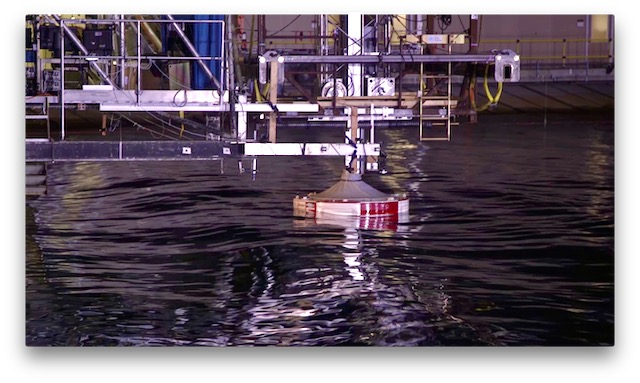

In [1]:
# logging
import logging
logging.basicConfig(level=logging.INFO)

# autograd (derivatives)
import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict

# other packages
import os

import capytaine as cpy
import matplotlib.pyplot as plt

# wecopttool
import wecopttool as wot

# create save directory
results_dir = 'results_kinematics'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

In [2]:
# mesh
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5  # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# frequencies
f0 = 0.05
nfreq = 50

# wave
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

## Cases

In [3]:
fb_sh = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb_h = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb_s = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")

# DOFs
fb_sh.add_translation_dof(name="SURGE")
fb_sh.add_translation_dof(name="HEAVE")
fb_s.add_translation_dof(name="SURGE")
fb_h.add_translation_dof(name="HEAVE")

# hydrostatics 
hs_data = wot.hydrostatics.hydrostatics(fb_sh)
mass_11 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[0, 0]
mass_13 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[0, 2]
mass_31 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 0]
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
stiffness_11 = wot.hydrostatics.stiffness_matrix(hs_data)[0, 0]
stiffness_13 = wot.hydrostatics.stiffness_matrix(hs_data)[0, 2]
stiffness_31 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 0]
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
mass_sh = np.array([[mass_11, mass_13], [mass_31, mass_33]])
mass_s = np.array([[mass_11]])
mass_h = np.array([[mass_33]])
stiffness_sh = np.array(
    [[stiffness_11, stiffness_13], [stiffness_31, stiffness_33]])
stiffness_s = np.array([[stiffness_11]])
stiffness_h = np.array([[stiffness_33]])

# kinematics
kinematics_sh_sh = np.eye(fb_sh.nb_dofs)
kinematics_sh_s = np.array([[1.0, 0.0]])
kinematics_sh_h = np.array([[0.0, 1.0]])
kinematics_sh_sh = np.eye(fb_sh.nb_dofs)
kinematics_s = np.eye(fb_s.nb_dofs)
kinematics_h = np.eye(fb_h.nb_dofs)

# PTO
names_sh = ["PTO_SURGE", "PTO_HEAVE"]
names_s = ["PTO_SURGE"]
names_h = ["PTO_HEAVE"]
pto_sh_sh = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_sh, names=names_sh)
pto_sh_s = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_s, names=names_s)
pto_sh_h = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_h, names=names_h)
pto_s = wot.pto.PseudoSpectralPTO(nfreq, kinematics_s, names=names_s)
pto_h = wot.pto.PseudoSpectralPTO(nfreq, kinematics_h, names=names_h)

# f_add 
f_add_sh_sh = pto_sh_sh.force_on_wec
f_add_sh_s = pto_sh_s.force_on_wec
f_add_sh_h = pto_sh_h.force_on_wec
f_add_s = pto_s.force_on_wec
f_add_h = pto_h.force_on_wec

# WEC
wec_sh_sh = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_sh)
wec_sh_s = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_s)
wec_sh_h = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_h)
wec_s = wot.WEC(fb_s, mass_s, stiffness_s, f0, nfreq, f_add=f_add_s)
wec_h = wot.WEC(fb_h, mass_h, stiffness_h, f0, nfreq, f_add=f_add_h)

# BEM files
fname_sh = os.path.join(results_dir, 'bem_sh.nc')
fname_s = os.path.join(results_dir, 'bem_s.nc')
fname_h = os.path.join(results_dir, 'bem_h.nc')


INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.


In [4]:
# one time (run, comment out, restart & rerun notebook)
# wec_sh_sh.run_bem()
# wec_sh_sh.hydro.added_mass[:, 0, 1] = 0.0
# wec_sh_sh.hydro.added_mass[:, 1, 0] = 0.0
# wec_sh_sh.hydro.radiation_damping[:, 0, 1] = 0.0
# wec_sh_sh.hydro.radiation_damping[:, 1, 0] = 0.0
# wec_sh_sh._del_impedance()
# wec_sh_sh.bem_calc_impedance()
# wec_sh_sh.write_bem(fname_sh)

# wec_s.run_bem()
# wec_s.write_bem(fname_s)

# wec_h.run_bem()
# wec_h.write_bem(fname_h)

In [5]:
# Read BEM
wec_sh_sh.read_bem(fname_sh)
wec_sh_s.read_bem(fname_sh)
wec_sh_h.read_bem(fname_sh)
wec_s.read_bem(fname_s)
wec_h.read_bem(fname_h)

INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.
INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.
INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculat

## Solve cases

In [6]:
# sh_sh
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_sh  # change
wec = wec_sh_sh  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_sh = {"wec_tdom": wec_tdom, 
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.45e-03, 1.98e-01, 8.12e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.46e-03, 1.98e-01, 7.51e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.47e-03, 2.00e-01, 4.45e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.48e-03, 2.07e-01, 1.08e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.50e-03, 2.42e-01, 8.71e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.56e-03, 4.21e-01, 4.66e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.85e-03, 1.31e+00, 2.32e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.23e-03, 5.59e+00, 1.04e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [9.99e-03, 2.36e+01, 2.92e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.15e-02, 2.83e+01, 3.01e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -416.77708839596846
            Iterations: 75
            Function evaluations: 89
            Gradient evaluations: 75
Average power: -416.77708839596846 W



In [7]:
# sh_s
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_s  # change
wec = wec_sh_s  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_s = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.12e-03, 8.47e-01, 1.33e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.13e-03, 8.47e-01, 1.36e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.14e-03, 8.43e-01, 1.49e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.15e-03, 8.25e-01, 2.14e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.16e-03, 7.37e-01, 5.37e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.22e-03, 2.97e-01, 2.15e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.48e-03, 1.90e+00, 1.01e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.74e-03, 1.27e+01, 4.77e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.06e-02, 6.28e+01, 1.85e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.06e-02, 1.50e+02, 2.77e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -276.77219893305926
            Iterations: 24
            Function evaluations: 37
            Gradient evaluations: 24
Average power: -276.77219893305926 W



In [8]:
# sh_h
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_h  # change
wec = wec_sh_h  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_h = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.13e-02, 4.34e-01, 1.92e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.20e-02, 4.35e-01, 1.58e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.25e-02, 4.35e-01, 9.78e-03]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.31e-02, 4.36e-01, 4.54e-03]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.31e-02, 4.37e-01, 3.10e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.32e-02, 4.41e-01, 1.58e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.33e-02, 4.59e-01, 7.33e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.35e-02, 5.60e-01, 3.89e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.40e-02, 1.11e+00, 2.07e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.45e-02, 3.70e+00, 8.44e+01]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -139.98586583104512
            Iterations: 36
            Function evaluations: 100
            Gradient evaluations: 36
Average power: -139.98586583104512 W



In [9]:
# s
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_s  # change
wec = wec_s  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_s = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.74e-02, 3.33e-01, 1.67e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.74e-02, 3.34e-01, 1.93e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.74e-02, 3.37e-01, 3.23e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.74e-02, 3.55e-01, 9.71e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.74e-02, 4.45e-01, 4.21e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.76e-02, 8.93e-01, 2.04e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.81e-02, 3.13e+00, 1.00e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.06e-02, 1.41e+01, 4.76e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.23e-02, 6.51e+01, 1.85e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.25e-02, 1.53e+02, 2.77e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -276.76729614120245
            Iterations: 32
            Function evaluations: 51
            Gradient evaluations: 32
Average power: -276.76729614120245 W



In [10]:
# h
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_h  # change
wec = wec_h  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_h = {"wec_tdom": wec_tdom,
             "wec_fdom": wec_fdom,
             "x_wec": x_wec,
             "x_opt": x_opt,
             "obj": obj,
             "res": res,
             "pto_tdom": pto_tdom,
             "pto_fdom": pto_fdom,
             }

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.53e-04, 3.71e-01, 3.73e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.53e-04, 3.71e-01, 3.38e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.53e-04, 3.70e-01, 1.62e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.53e-04, 3.67e-01, 7.19e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.52e-04, 3.52e-01, 5.11e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.50e-04, 2.77e-01, 2.69e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.40e-04, 9.48e-02, 1.32e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [7.91e-04, 1.87e+00, 5.66e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.26e-04, 7.85e+00, 1.20e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.25e-04, 7.85e+00, 1.20e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -140.0036616347171
            Iterations: 69
            Function evaluations: 69
            Gradient evaluations: 69
Average power: -140.0036616347171 W



## Results

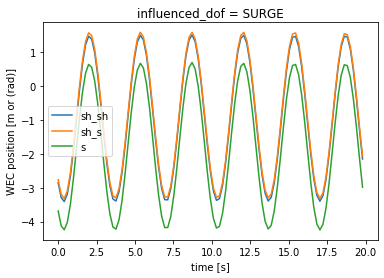

In [11]:
# WEC Position - Surge
results_sh_sh["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='sh_sh')
results_sh_s["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='sh_s')
results_s["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='s')
plt.legend()

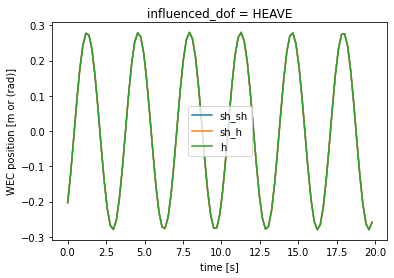

In [12]:
# WEC Position - Heave
results_sh_sh["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='sh_sh')
results_sh_h["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='sh_h')
results_h["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='h')
plt.legend()

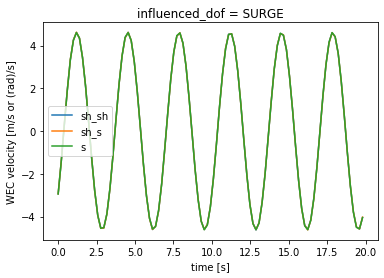

In [13]:
# WEC Velocity - Surge
results_sh_sh["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='sh_sh')
results_sh_s["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='sh_s')
results_s["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='s')
plt.legend()

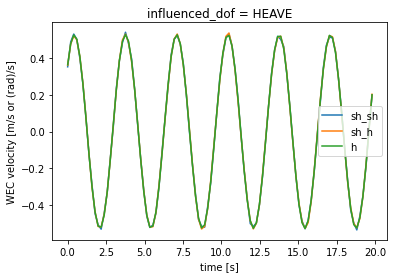

In [14]:
# WEC Velocity - Heave
results_sh_sh["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='sh_sh')
results_sh_h["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='sh_h')
results_h["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='h')
plt.legend()

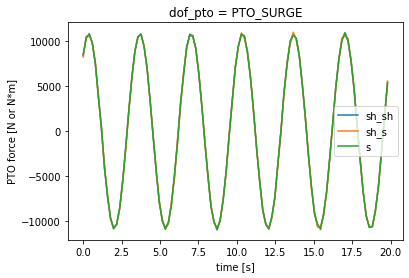

In [15]:
# PTO Force - Surge
results_sh_sh["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='sh_sh')
results_sh_s["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='sh_s')
results_s["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='s')
plt.legend()

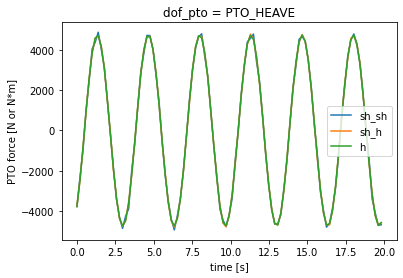

In [16]:
# PTO Force - Heave
results_sh_sh["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='sh_sh')
results_sh_h["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='sh_h')
results_h["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='h')
plt.legend()

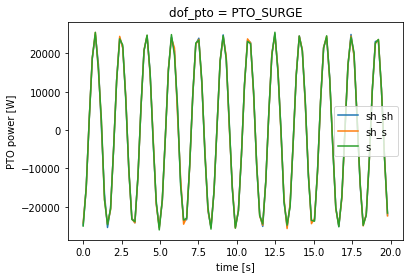

In [17]:
# PTO Power - Surge
results_sh_sh["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='sh_sh')
results_sh_s["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='sh_s')
results_s["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='s')
plt.legend()

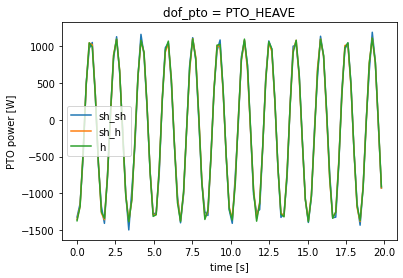

In [18]:
# PTO Power - Heave
results_sh_sh["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='sh_sh')
results_sh_h["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='sh_h')
results_h["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='h')
plt.legend()